In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform

In [7]:
df_summary = pd.read_csv('../References/London_Multiplex_Transport/Dataset/london_transport_disruptions_summary.txt', sep = ' ', engine='python')
df_summary.head(5)

#DISRUP_ID             LAYER        STATION_A          STATION_B  \
0      DISR1      metropolitan          aldgate        bakerstreet   
1      DISR2  hammersmith&city          barking           moorgate   
2      DISR3               dlr          beckton        canningtown   
3      DISR4        overground  claphamjunction        surreyquays   
4      DISR5        overground         richmond  willesdenjunction   

   FREQUENCY%  DAMAGED_NODES%  
0      3.3457           2.439  
1      2.8914           3.523  
2      2.5609           2.439  
3      2.0240           1.897  
4      1.9413           1.626

In [8]:
nodes_df = pd.read_csv('../References/London_Multiplex_Transport/Dataset/london_transport_nodes.txt', sep = ' ', engine='python')
nodes_df.head(5)

nodeID          nodeLabel    nodeLat  nodeLong
0       0          abbeyroad  51.531952  0.003738
1       1            westham  51.528526  0.005332
2       2       actoncentral  51.508758 -0.263416
3       3  willesdenjunction  51.532234 -0.243895
4       4          actontown  51.503071 -0.280288

In [9]:
layers = pd.read_csv('../References/London_Multiplex_Transport/Dataset/london_transport_layers.txt', sep = ' ', engine='python')
layers.head(5)

layerID   layerLabel
1 Tube       (All underground   lines  aggregated)
2 Overground NaN  NaN            None         None
3 DLR        NaN  NaN            None         None

In [20]:
edges_file = '../References/London_Multiplex_Transport/Dataset/london_transport_raw.edges'
edges_df = pd.read_csv(edges_file, sep=' ', names=['Line', 'From Station', 'To Station'])

edges_df.head(5)

Line       From Station       To Station
0  bakerloo  harrow&wealdstone           kenton
1  bakerloo             kenton      southkenton
2  bakerloo        southkenton     northwembley
3  bakerloo       northwembley   wembleycentral
4  bakerloo     wembleycentral  stonebridgepark

### Creating functions to assign line_color and line_stations

In [11]:
def assign_line_colors(edges_df):
    line_colors = {
        'bakerloo': 'brown',
        'circle': 'yellow',
        'district': 'green',
        'hammersmith&city': 'pink',
        'jubilee': 'gray',
        'metropolitan': 'magenta',
        'northern': 'black',
        'piccadilly': 'blue',
        'victoria': 'lightblue',
        'waterloo&city': 'cyan',
        'overground': 'orange',
        'dlr': 'turquoise',
        'central': 'red'  # Adding Central line for completeness
        
    }
    
    line_stations = {}
    for line in line_colors:
        line_stations[line] = set(edges_df[edges_df['Line'] == line]['From Station']).union(set(edges_df[edges_df['Line'] == line]['To Station']))
    
    return line_colors, line_stations

In [12]:
line_colors, line_stations = assign_line_colors(edges_df)

### Plotting the TfL Network

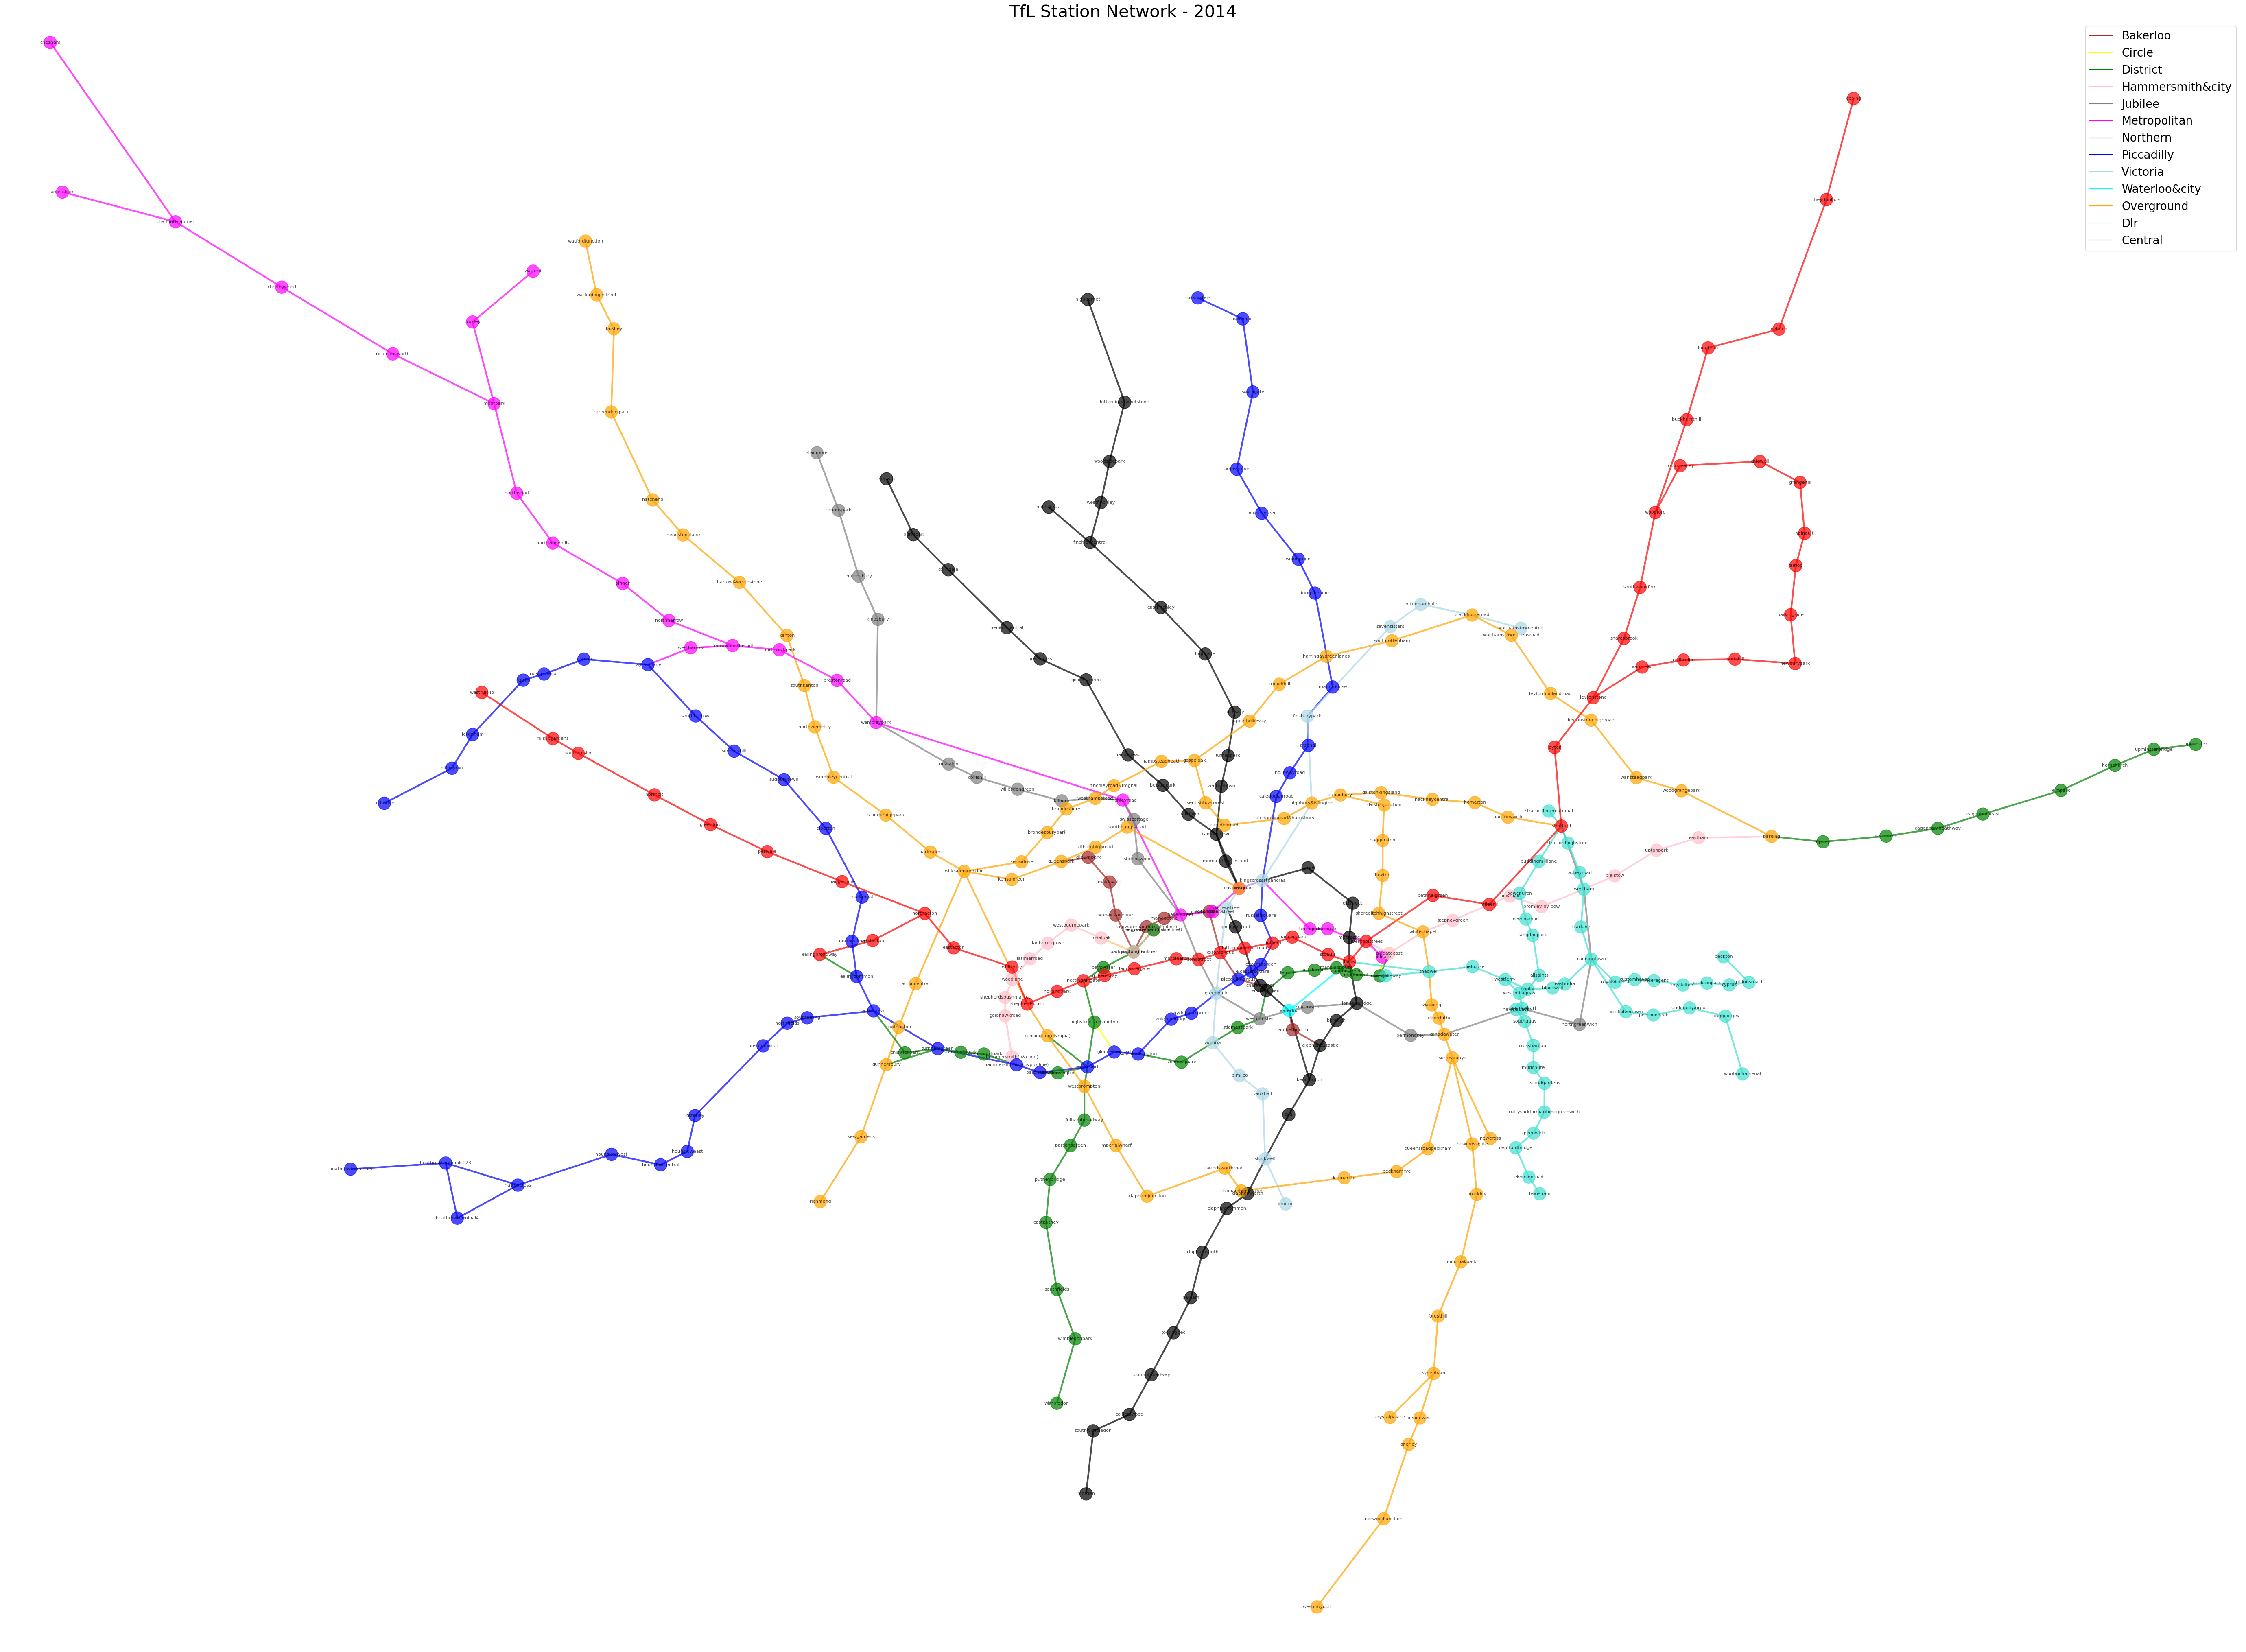

In [13]:
G = nx.Graph()

# Add nodes with positions
pos = {}
for _, row in nodes_df.iterrows():
    pos[row['nodeLabel']] = (row['nodeLong'], row['nodeLat'])

# Add nodes with colors
node_color_map = {}
for line, stations in line_stations.items():
    for station in stations:
        G.add_node(station)
        if station in pos:
            node_color_map[station] = line_colors[line]
        else:
            node_color_map[station] = 'gray'  # Station not in nodes_df

# Add edges with colors
for _, row in edges_df.iterrows():
    line = row['Line']
    if row['From Station'] in line_stations[line] and row['To Station'] in line_stations[line]:
        G.add_edge(row['From Station'], row['To Station'], color=line_colors[line])
    else:
        G.add_edge(row['From Station'], row['To Station'], color='gray')  # Edge not valid

# Draw the graph
plt.figure(figsize=(55, 40))
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, node_color=list(node_color_map.values()), font_color='black', edge_color=[G[u][v]['color'] for u, v in G.edges()], width=3, alpha=0.7)

# Create custom legend for line colors
legend_patches = []
for line, color in line_colors.items():
    legend_patches.append(plt.Line2D([], [], color=color, label=line.capitalize(), linestyle='-'))

plt.legend(handles=legend_patches, fontsize=20)
plt.xlim(-0.63, 0.27)
plt.ylim(51.37, 51.71)
plt.title('TfL Station Network - 2014', fontsize=30)
plt.show()

### Applying Repulsion

In [32]:
def log_scale_coordinates(nodes_df, center_lat=51.5074, center_lon=-0.1278, scale_factor=0.1):
    scaled_df = nodes_df.copy()
    
    # Calculate the distance from the center
    scaled_df['dist_lat'] = scaled_df['nodeLat'] - center_lat
    scaled_df['dist_lon'] = scaled_df['nodeLong'] - center_lon
    
    # Apply logarithmic scaling
    scaled_df['scaled_lat'] = np.sign(scaled_df['dist_lat']) * np.log1p(np.abs(scaled_df['dist_lat']) / scale_factor)
    scaled_df['scaled_lon'] = np.sign(scaled_df['dist_lon']) * np.log1p(np.abs(scaled_df['dist_lon']) / scale_factor)
    
    # Calculate new coordinates
    scaled_df['new_lat'] = center_lat + scaled_df['scaled_lat']
    scaled_df['new_lon'] = center_lon + scaled_df['scaled_lon']
    
    # Ensure the new coordinates are within the specified limits
    scaled_df['new_lat'] = np.clip(scaled_df['new_lat'], 51.37, 51.71)
    scaled_df['new_lon'] = np.clip(scaled_df['new_lon'], -0.63, 0.27)
    
    return scaled_df

nodes_df = pd.read_csv('../References/London_Multiplex_Transport/Dataset/london_transport_nodes.txt', delimiter=' ', index_col='nodeID')

scaled_nodes_df = log_scale_coordinates(nodes_df)

### Plotting Replusion

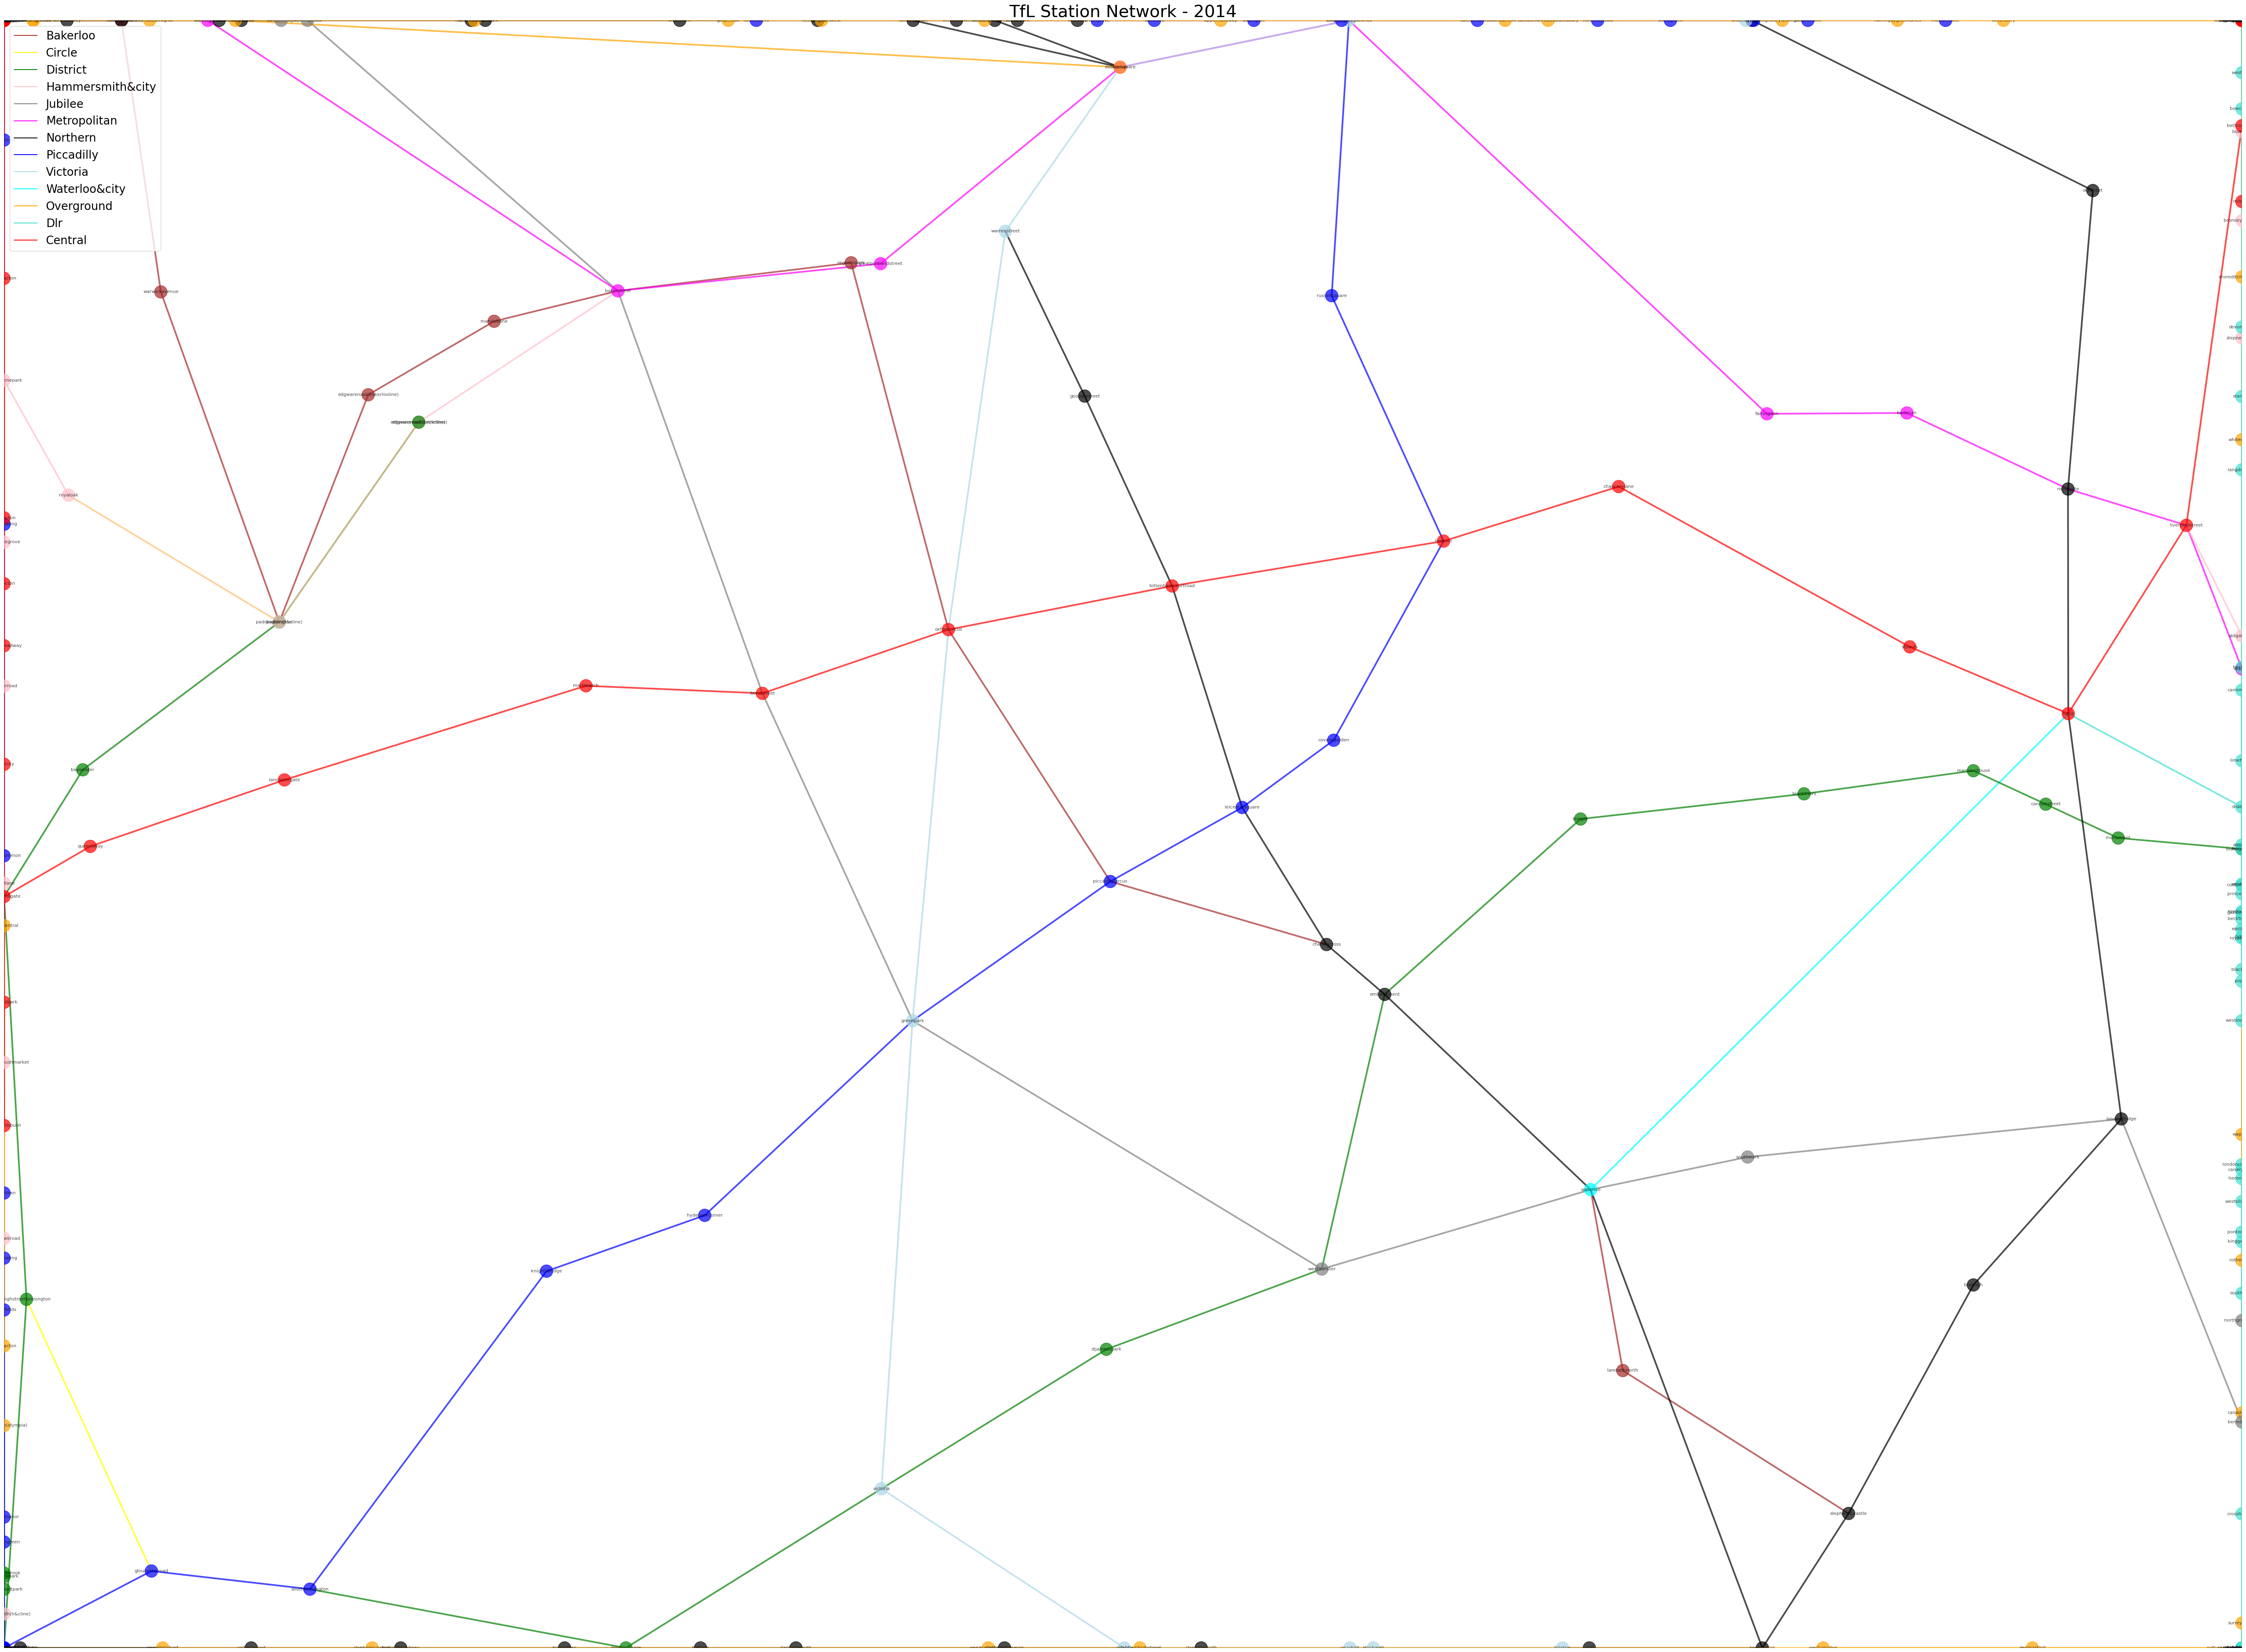

In [33]:
G = nx.Graph()

# Add nodes with positions
pos = {row['nodeLabel']: (row['new_lon'], row['new_lat']) for _, row in scaled_nodes_df.iterrows()}

# Add nodes with colors
node_color_map = {}
for line, stations in line_stations.items():
    for station in stations:
        G.add_node(station)
        if station in pos:
            node_color_map[station] = line_colors[line]
        else:
            node_color_map[station] = 'gray'  # Station not in nodes_df

# Add edges with colors
for _, row in edges_df.iterrows():
    line = row['Line']
    if row['From Station'] in line_stations[line] and row['To Station'] in line_stations[line]:
        G.add_edge(row['From Station'], row['To Station'], color=line_colors[line])
    else:
        G.add_edge(row['From Station'], row['To Station'], color='gray')  # Edge not valid

# Draw the graph
plt.figure(figsize=(55, 40))
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, node_color=list(node_color_map.values()), font_color='black', edge_color=[G[u][v]['color'] for u, v in G.edges()], width=3, alpha=0.7)

# Create custom legend for line colors
legend_patches = []
for line, color in line_colors.items():
    legend_patches.append(plt.Line2D([], [], color=color, label=line.capitalize(), linestyle='-'))

plt.legend(handles=legend_patches, fontsize=20)
plt.title('TfL Station Network - 2014', fontsize=30)
plt.xlim(-0.63, 0.27)
plt.ylim(51.37, 51.71)
plt.show()

In [34]:
def simple_force_directed_layout(nodes_df, iterations=50, k=0.1):
    layout_df = nodes_df.copy()
    
    for _ in range(iterations):
        for i, node in layout_df.iterrows():
            dx, dy = 0, 0
            for j, other in layout_df.iterrows():
                if i != j:
                    delta_x = node['nodeLong'] - other['nodeLong']
                    delta_y = node['nodeLat'] - other['nodeLat']
                    distance = max(0.01, np.sqrt(delta_x**2 + delta_y**2))
                    force = k / distance
                    dx += delta_x * force
                    dy += delta_y * force
            
            layout_df.at[i, 'new_lon'] = node['nodeLong'] + dx
            layout_df.at[i, 'new_lat'] = node['nodeLat'] + dy
    
    # Ensure the new coordinates are within the specified limits
    layout_df['new_lat'] = np.clip(layout_df['new_lat'], 51.37, 51.71)
    layout_df['new_lon'] = np.clip(layout_df['new_lon'], -0.63, 0.27)
    
    return layout_df

force_directed_nodes_df = simple_force_directed_layout(nodes_df)

In [ ]:
print(force_directed_nodes_df[['nodeLabel', 'nodeLat', 'nodeLong', 'new_lat', 'new_lon']].head(40))

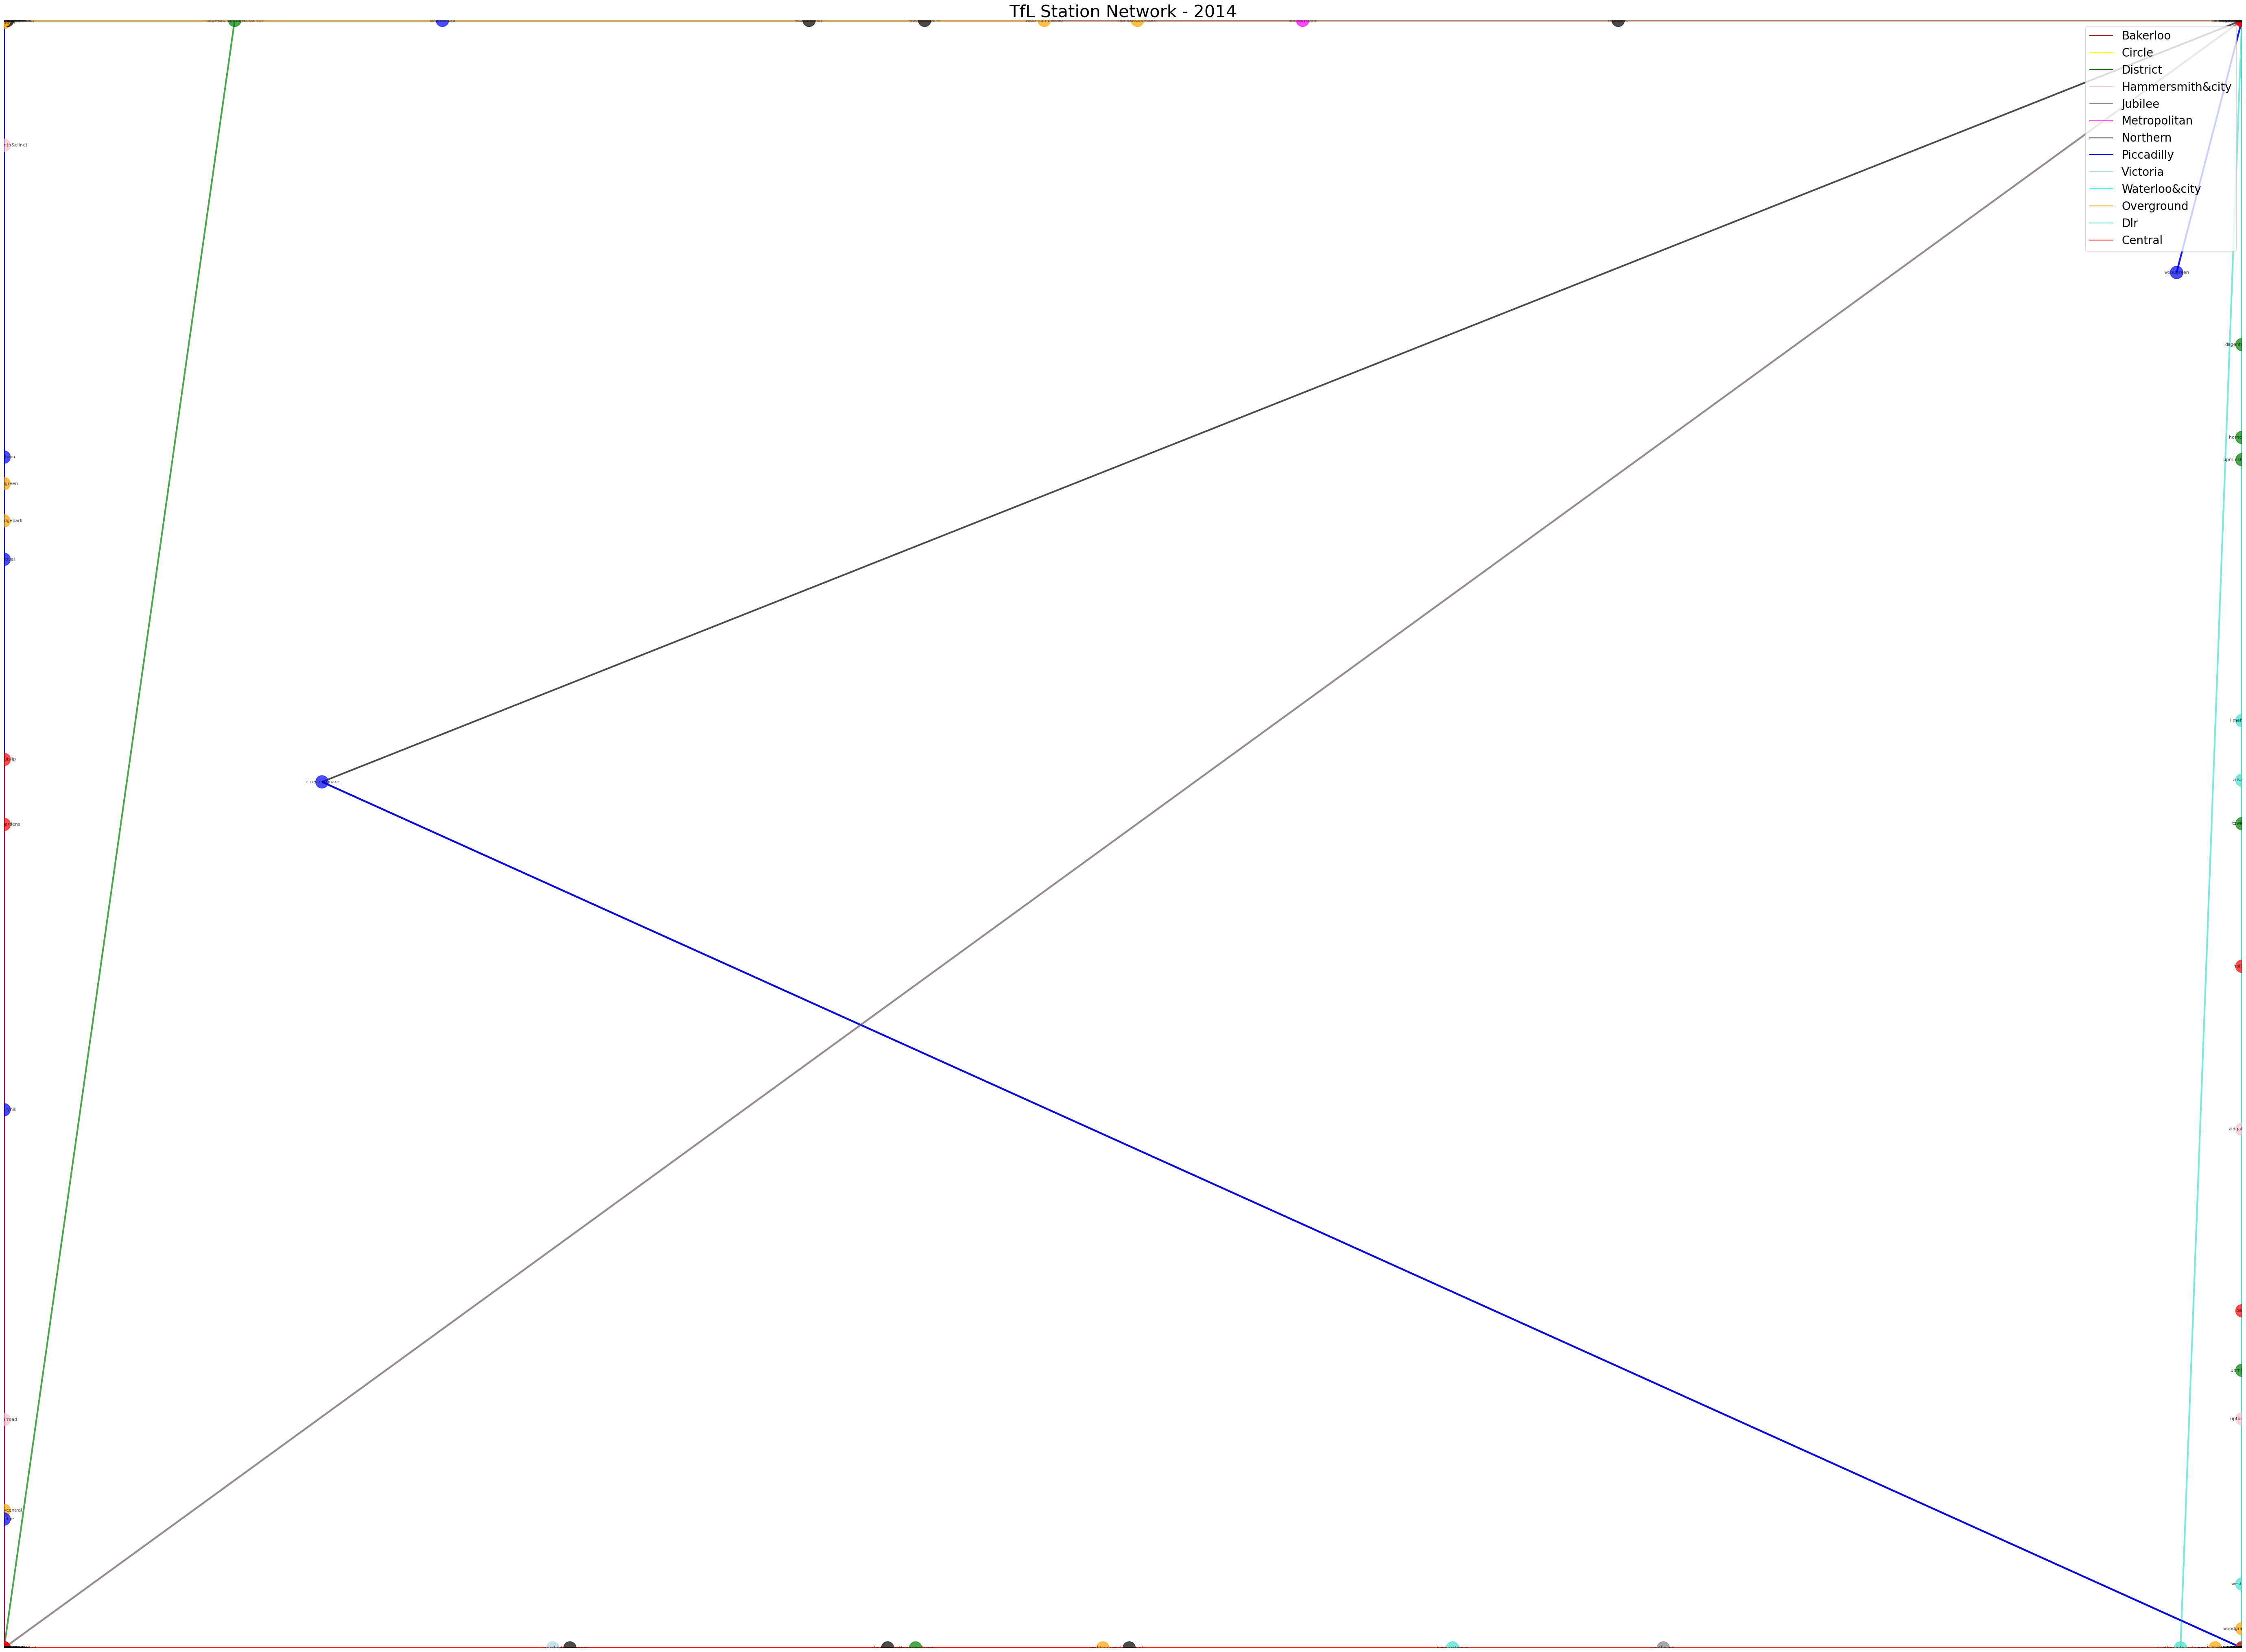

In [31]:
G = nx.Graph()

# Add nodes with positions
pos = {row['nodeLabel']: (row['new_lon'], row['new_lat']) for _, row in force_directed_nodes_df.iterrows()}

# Add nodes with colors
node_color_map = {}
for line, stations in line_stations.items():
    for station in stations:
        G.add_node(station)
        if station in pos:
            node_color_map[station] = line_colors[line]
        else:
            node_color_map[station] = 'gray'  # Station not in nodes_df

# Add edges with colors
for _, row in edges_df.iterrows():
    line = row['Line']
    if row['From Station'] in line_stations[line] and row['To Station'] in line_stations[line]:
        G.add_edge(row['From Station'], row['To Station'], color=line_colors[line])
    else:
        G.add_edge(row['From Station'], row['To Station'], color='gray')  # Edge not valid

# Draw the graph
plt.figure(figsize=(55, 40))
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, node_color=list(node_color_map.values()), font_color='black', edge_color=[G[u][v]['color'] for u, v in G.edges()], width=3, alpha=0.7)

# Create custom legend for line colors
legend_patches = []
for line, color in line_colors.items():
    legend_patches.append(plt.Line2D([], [], color=color, label=line.capitalize(), linestyle='-'))

plt.legend(handles=legend_patches, fontsize=20)
plt.title('TfL Station Network - 2014', fontsize=30)
plt.xlim(-0.63, 0.27)
plt.ylim(51.37, 51.71)
plt.show()